In [312]:
import numpy as np
import pandas as pd

import folium

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [313]:
collected_data = pd.read_csv('../../main/data/data_d_final/2d201_1230_collected_data.csv')

collected_data.columns

Index(['지역', '위도', '경도', '쏘카존 수', '녹지', '주거', '공업', '상업', '인구', '대학교 수',
       '아파트 수', '지하철역 수', '정류장 수', '환승역 수', '행복주택 수'],
      dtype='object')

# 군집화 (k-Means Clustering)

In [314]:
X = collected_data.copy()

In [315]:
regions = X[['지역']]
X.drop('지역', axis=1, inplace=True)
X.head()

,위도,경도,쏘카존 수,녹지,주거,공업,상업,인구,대학교 수,아파트 수,지하철역 수,정류장 수,환승역 수,행복주택 수
0,37.303971,127.001743,18,0.272727,0.727273,0.000000,0.000000,271012,4,200,1,409,0,0
1,37.257687,126.963532,16,0.625000,0.312500,0.062500,0.000000,367004,1,159,4,537,0,1
2,37.282570,127.011718,20,0.136364,0.409091,0.000000,0.454545,192225,0,65,4,185,2,1
3,37.259600,127.042341,34,0.142857,0.571429,0.285714,0.000000,360127,21,129,6,380,0,3
4,37.234346,127.192965,29,0.823529,0.058824,0.000000,0.117647,259872,15,112,9,1234,0,1


In [316]:
distortions = []

K = range(1,20)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init=50, max_iter=500)
    # centroid들의 intialization이 50종류이다.
    # 각 종류의 initialization에 대하여 iteration을 최대 500번 진행한다. (500번보다 적은 iteration동안 centroid가 더이상 움직이지 않으면, 거기서 멈춘다.)
    kmean.fit(X)
    distortions.append(kmean.inertia_)

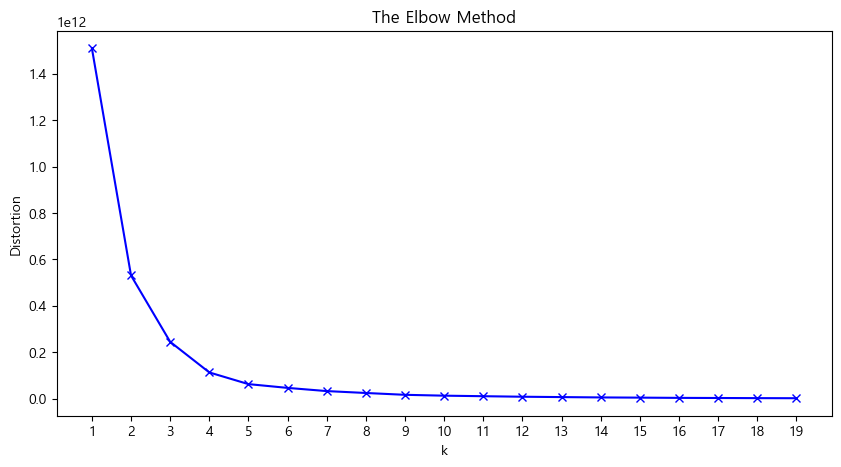

In [317]:
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.xticks(K)
plt.title('The Elbow Method')
plt.show()

In [318]:
# elbow method의 결과로 클러스터의 개수를 5개로 정한다(4개나 6개여도 크게 이상은 없을 것 같다.)
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
y = kmeans.labels_
regions['군집'] = y
for k in range(5):
    print('cluster ', k, ' : ', list(regions[regions['군집'] == k]['지역']))

cluster  0  :  ['수원시 권선구', '수원시 영통구', '용인시 수지구', '안산시 상록구', '안산시 단원구', '안양시 동안구', '광주시', '광명시', '하남시', '고양시 일산동구', '고양시 일산서구']
cluster  1  :  ['부천시', '화성시', '남양주시']
cluster  2  :  ['양평군', '여주시', '과천시', '포천시', '동두천시', '가평군', '연천군']
cluster  3  :  ['용인시 기흥구', '성남시 분당구', '평택시', '시흥시', '김포시', '고양시 덕양구', '파주시', '의정부시']
cluster  4  :  ['수원시 장안구', '수원시 팔달구', '용인시 처인구', '성남시 수정구', '성남시 중원구', '안양시 만안구', '군포시', '오산시', '이천시', '안성시', '의왕시', '양주시', '구리시']


In [319]:
print(X.shape)
print(y.shape)

(42, 14)
(42,)


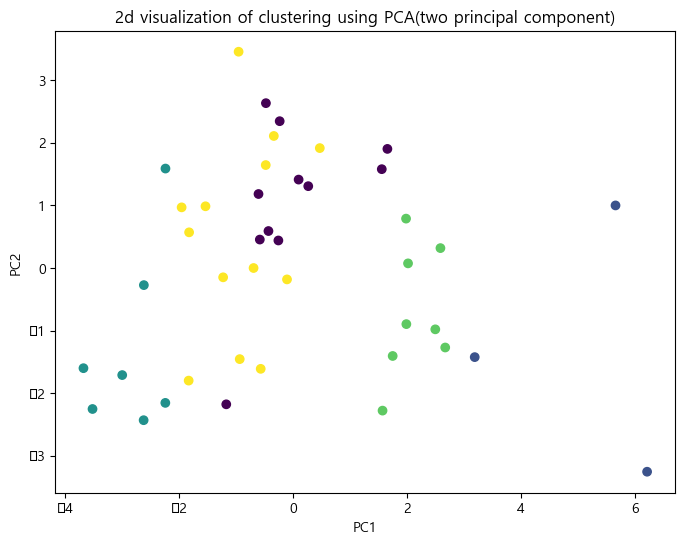

In [320]:
# X에 대하여 standardization 및 PCA를 적용한다. PCA에 간략한 설명은 다음과 같다.
# X는 42개의 14차원의 벡터이다. 이 42개의 벡터들은 서로 orthogonal하지 않은 상태이다.
# 이것을 새로운 42개의 14차원 벡터들로 변환하여 Xt를 만들되, 각각의 벡터들이 서로 orthogonal하게 변환하는 것이다.
# (조금 더 정확하게는, types와 그 transpose의 곱인 square symmetric matrix N에 대하여
# 42개의 벡터들은 N의 eigenvector가 되고, 그에 대응되는 eigenvalue들은 절댓값이 큰 순으로 정렬되어 있다.)
# Xt의 첫 벡터 PC1(the first principal component)는 X를 projection했을 때, 가장 많은 정보가 보존되는 벡터이다.
# Xt의 두번째 벡터 PC2는 PC1과 직교하는 벡터이면서 X를 projection했을 때, 가장 많은 정보가 보존되는 벡터이다.
# 즉, PC1과 PC2의 방향은, 원래 데이터 X의 정보를 가장 잘 보존시키는 두 개의 벡터이다.
# 이 두 개의 방향에 대한 두 개의 성분들을 고려하면
# 14차원의 정보를 2차원의 정보로 효율적으로 축소시킨 셈이다(dimensionality reduction).
# 이번 코드에서는 이러한 차원축소를 통해, clustering을 시각화하는 데에 사용했다.
# standardization은 이러한 PCA가 더 잘 작용되도록 한다.
# 하지만 이번 코드에서는 standardization을 적용하지 않았더라도 clustering이 이전과 비슷하게 잘 보이기는 한다.

pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
plt.figure(figsize=(8,6))
Xt = pipe.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
#plt.legend(handles=plot.legend_elements()[0], labels=list(winedata['target_names']))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2d visualization of clustering using PCA(two principal component)")
plt.show()

In [333]:
Xy = X.copy()
Xy['cluster'] = y
Xy.groupby('cluster').mean()

,위도,경도,쏘카존 수,녹지,주거,공업,상업,인구,대학교 수,아파트 수,지하철역 수,정류장 수,환승역 수,행복주택 수
cluster,,,,,,,,,,,,,,
0,37.421411,126.956040,27.727273,0.464258,0.456148,0.051136,0.028458,332181.727273,4.545455,138.454545,5.272727,545.727273,0.454545,0.909091
1,37.446381,126.930976,56.666667,0.441551,0.480140,0.069300,0.009009,812195.666667,14.333333,431.000000,11.333333,1928.666667,1.333333,8.333333
2,37.706587,127.271268,5.428571,0.859127,0.117063,0.011905,0.011905,93776.857143,4.000000,45.000000,3.571429,763.571429,0.000000,0.428571
3,37.473013,126.930534,44.875000,0.614231,0.328389,0.037436,0.019944,492640.750000,6.000000,273.125000,11.000000,1304.375000,1.125000,4.500000
4,37.354211,127.093336,15.769231,0.542483,0.347954,0.038967,0.070596,222699.076923,6.076923,117.000000,3.692308,644.615385,0.461538,1.615385


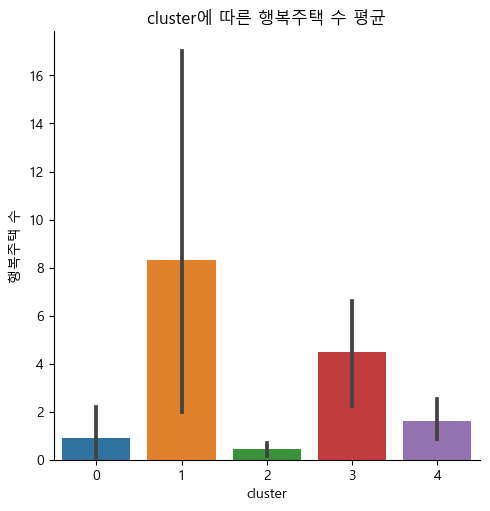

In [322]:
# 위에서 진행한 군집화는, "행복주택 수"라는 feature를 잘 반영한 군집화임을 확인할 수 있다.
plt.rcParams['font.family'] = 'Malgun Gothic'
# sns.catplot(x='cluster', y='쏘카존 수', data=X, kind='bar').set(title='cluster에 따른 쏘카존 수 평균')
# sns.catplot(x='cluster', y='대학교 수', data=X, kind='bar').set(title='cluster에 따른 대학교 수 평균')
# sns.catplot(x='cluster', y='아파트 수', data=X, kind='bar').set(title='cluster에 따른 아파트 수 평균')
# sns.catplot(x='cluster', y='지하철역 수', data=X, kind='bar').set(title='cluster에 따른 지하철역 수 평균')
# sns.catplot(x='cluster', y='정류장 수', data=X, kind='bar').set(title='cluster에 따른 정류장 수 평균')
# sns.catplot(x='cluster', y='환승역 수', data=X, kind='bar').set(title='cluster에 따른 환승역 수 평균')
sns.catplot(x='cluster', y='행복주택 수', data=X, kind='bar').set(title='cluster에 따른 행복주택 수 평균')

# `follium`을 이용한 시각화

## 쏘카존 수 시각화

In [323]:
latitude = 37.532600
longitude = 127.024612

map_gg = folium.Map(location=[latitude, longitude], zoom_start=9)

In [325]:
cities = collected_data[['지역', '위도', '경도', '쏘카존 수']]
cities.head()

,지역,위도,경도,쏘카존 수
0,수원시 장안구,37.303971,127.001743,18
1,수원시 권선구,37.257687,126.963532,16
2,수원시 팔달구,37.282570,127.011718,20
3,수원시 영통구,37.259600,127.042341,34
4,용인시 처인구,37.234346,127.192965,29


In [331]:
zcounts = folium.map.FeatureGroup()
n_mean = collected_data['쏘카존 수'].mean()

for lat, lng, region, zcount in zip(collected_data['위도'],
                            collected_data['경도'],
                            collected_data['지역'],
                            number_of_occurences['쏘카존 수']):
    zcounts.add_child(
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=zcount/n_mean*5, # define how big you want the circle markers to be
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            tooltip = str(region) + ', ' + str(zcount) + '개의 쏘카존'
        )
    )

map_gg.add_child(zcounts)

In [338]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, region, cluster in zip(X['위도'], X['경도'], X.index, y):
    #label = folium.Popup(str(city)+ ','+str(state) + '- Cluster ' + str(cluster), parse_html=True)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        tooltip = str(region) + '- Cluster ' + str(cluster),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

### We can see that cluster 0, the one most affected by snow events, are mainly located to the north border of USA, very close to Canada!

### And here I conclude this notebook suggesting some future work! Maybe the use of 5 clusters may reveal to us a better look into our data. It seems to me that cluster 1 are not well defined! Furthermore, a better investigation of each cluster may show us other differences among them!

### Thank you,
### Lucas